                macd    signal      hist
2023-03-01  0.000000  0.000000  0.000000
2023-03-02  0.386097  0.077219  0.308877
2023-03-03  1.017642  0.265304  0.752338
2023-03-06  1.626885  0.537620  1.089265
2023-03-07  1.868692  0.803834  1.064857
2023-03-08  2.000949  1.043257  0.957691
2023-03-09  1.971680  1.228942  0.742739
2023-03-10  1.628730  1.308900  0.319831
2023-03-13  1.766661  1.400452  0.366209


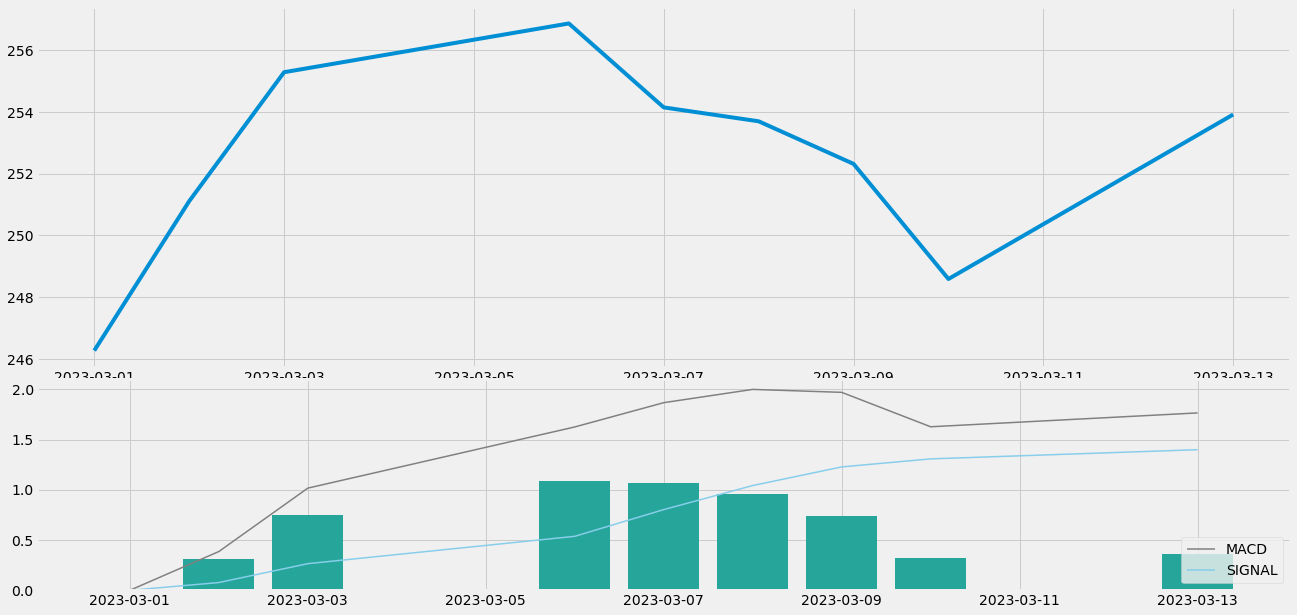

In [6]:
import requests
import pandas as pd
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt

AVKey = "0T2WORTYUXU5Z4XA"

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

url = 'https://www.alphavantage.co/query?function=MACD&symbol=IBM&interval=daily&series_type=open&apikey={AVKey}'
r = requests.get(url)
data = r.json()


def get_historical_data(symbol, start_date = None):
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={AVKey}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

stock = get_historical_data('MSFT', '2023-03-01')

def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

stock_macd = get_macd(stock['close'], 26, 12, 9)
print(stock_macd)
stock_macd.tail()

def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(stock['close'], stock_macd['macd'], stock_macd['signal'], stock_macd['hist'])